## References

Inspired From:
**Sophia Young** and **Lance Martin**. _"Advance RAG Control Flow with Mistral and LangChain: Corrective RAG, Self-RAG, Adaptive RAG."_


# Installing Required Packages


In [1]:
!pip install langchain langchain-community langchain-huggingface langgraph langchain_experimental pymupdf tiktoken sentence_transformers chromadb  duckduckgo-search

# Imports


In [2]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.schema import Document
from langchain_core.runnables import RunnableLambda
from langchain_community.utilities import SQLDatabase

from langchain_community.tools import DuckDuckGoSearchResults
from langgraph.graph import END, StateGraph

from typing_extensions import TypedDict
from typing import Literal, List
import datetime

In [3]:
model_name = "llama3:instruct"
#model_name = "llama3.1:8b-instruct-q4_0"
account_id = "1234567892"
CURRENT_DATE_AND_DAY = f"{datetime.datetime.now().strftime('%Y-%m-%d')}, {datetime.datetime.now().strftime('%A')}"

# LLM


In [4]:
llm = ChatOllama(base_url="http://localhost:11434", model=model_name, temperature=0)

# Indexing


In [5]:
loader = PyMuPDFLoader(file_path=r"data/Citi_Marketplace.pdf")
documents = loader.load()
documents[0:3]

[Document(metadata={'source': 'data/Citi_Marketplace.pdf', 'file_path': 'data/Citi_Marketplace.pdf', 'page': 0, 'total_pages': 130, 'format': 'PDF 1.6', 'title': 'Client Manual - Consumer Accounts', 'author': 'Citi', 'subject': '', 'keywords': '', 'creator': 'Adobe InDesign 18.1 (Windows)', 'producer': 'Adobe PDF Library 17.0', 'creationDate': "D:20230828170222-04'00'", 'modDate': "D:20240612164435-04'00'", 'trapped': ''}, page_content='Client Manual — \nConsumer Accounts\nU.S. Markets\nEffective September 7, 2023\nWelcome to Citibank and thank you for choosing us for your banking needs.\nThis manual contains some important information you should know about your \ndeposit relationship with Citibank. It is an agreement between you and us. From \nAccount Transactions to Electronic Banking and beyond, we want you to understand \nhow our products and services work, as well as to understand some of the important \nresponsibilities that exist — yours and ours.\nSome of these responsibilities

In [6]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=20)
doc_splits = text_splitter.split_documents(documents=documents)

In [7]:
embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
db = Chroma.from_documents(
    documents=doc_splits,
    embedding=embedding_function,
    collection_name="citi-manuals",
    # persist_directory="citi-vector-store",
)

c:\Users\agadi\Documents\A\PythonProjects\Cricket-Bot\.venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [8]:
retriever = db.as_retriever(search_kwargs={"k": 4})

In [9]:
query = "Whats the minimum balance we need to have?"
docs = db.similarity_search(query)

# print results
for doc in docs:
    print(doc.page_content)
    print("-" * 50)

Minimum Balance Requirement 
There is a minimum balance of $100 to maintain the Citibank® Savings Plus account. We reserve the right to 
close the account if the account balance falls below the minimum balance. 
Interest Rates 
The interest rates for the Citibank® Savings Plus account are variable, determined by Citibank at its sole 
discretion and can change at any time. For current interest rates and Annual Percentage Yields, please call
--------------------------------------------------
a minimum combined average monthly balance of $1,000,000 in eligible linked deposit, retirement and 
investment accounts.
Your Citigold® relationship will change from the Citigold® Private Client to Citigold® Account Package if 
we determine that your combined average monthly balances in Citigold® Private Client does not meet the 
Citigold® Private client required minimum combined average monthly balance of $1,000,000 in eligible 
linked deposit, retirement and investment accounts.
------------------

# Router to route to the appropriate

### Adaptive RAG


In [10]:
llm_func = OllamaFunctions(
    base_url="http://localhost:11434", model=model_name, temperature=0
)

In [11]:
class RouteQuery(BaseModel):
    """Route user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web", "sql"] = Field(
        description="Given a user question choose to route it to web or a vector store or sql."
    )


structured_llm_router = llm_func.with_structured_output(RouteQuery)

system_message = """
You are an expert at routing a user question to a vectorstore or web.
The vectorstore contains documents related to - policies, deposit relationship, minimum balances, agreement, Account Transactions, Electronic Banking, products, services, responsibilities, customer, state laws, additional agreements, terms and conditions, arbitration provision, disputes.
Use the vectorstore for the questions on these topics. 
Use SQL if the question can be answered by applying SQL queries on Account table and Transaction Table. 
For all else, use web."""

route_prompt = ChatPromptTemplate.from_messages(
    [("system", system_message), ("human", "{question}")]
)

question_router = route_prompt | structured_llm_router
# print(question_router.invoke("Will the bank be closed this Friday?"))

# Grader to grade retrived documents

### Corrective RAG


In [12]:
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents"""

    binary_score: Literal["yes", "no"] = Field(
        description="Documents are relevant to the question 'yes' or 'no'"
    )


structured_llm_grader = llm_func.with_structured_output(GradeDocuments)

system_message = """
You are a grader assessing relevance of a retrieved document to a user question.
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_message),
        ("human", "Retreived Document: \n\n {document} User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
# question = "I have Savings Account and whats the minimum balance I need to maintain?"
# docs = retriever.invoke(question)
# for doc in docs:
#     print(doc.page_content)
#     print(retrieval_grader.invoke({"question": question, "document":doc}))
#     print("-",50)

# Generate Answer


In [13]:
rag_template = """
You are an helpful virtual assistant chatbot of Citi bank for question-answering tasks. Do not let the user know uou are answering from a context. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
"""
rag_prompt = PromptTemplate.from_template(template=rag_template)

rag_chain = rag_prompt | llm | StrOutputParser()

# untested_answer = rag_chain.invoke({"context" :docs, "question":question})
# print(untested_answer)

# Hallucination Grader


In [14]:
class HallucinationGrader(BaseModel):
    """Binary score for hallucination present in the generation answer"""

    binary_score: Literal["yes", "no"] = Field(
        description="Answer is grounded in the facts, 'yes' or 'no"
    )


structured_llm_grader = llm_func.with_structured_output(HallucinationGrader)

system_message = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_message),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
# hallucination_grader.invoke({"documents": docs, "generation": untested_answer})

# Answer Grader


In [15]:
class AnswerGrader(BaseModel):
    # """Binary score to assess answer adresses question."""

    binary_score: Literal["yes", "no"] = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


structured_llm_grader = llm_func.with_structured_output(AnswerGrader)

system_message = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_message),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
# answer_grader.invoke({"question": question,"generation": untested_answer})

# Web Search Tool


In [16]:
web_search_tool = DuckDuckGoSearchResults()

# Generate SQL Query


In [17]:
sql_db = SQLDatabase.from_uri(
    r"sqlite:///data/bank.sqlite", sample_rows_in_table_info=3
)

In [18]:
system_message = """ 
### Instructions:
Your task is to convert a question into a SQL query, given a sqlite database schema.
Adhere to these rules:
- **Apply a WHERE condition to every query based on account_number; always use the account number exactly as ACC_NUM. Do not take account number input from the user** 
- **Deliberately go through the question and database schema word by word** to appropriately answer the question
- **Use Table Aliases** to prevent ambiguity. If you are using alias, use only alias with columns, donot use table name with columns
- When creating a ratio, always cast the numerator as float
- Use the built in functions when the date is involved eg: DATE('now', '-7 days')
- **Output just the query nothing else**
- **Donot include any of escape sequneces**
- Today's date and day are {CURRENT_DATE_AND_DAY}
- Never use * to query all columns
- Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.

### Input:
Generate a SQL query that answers the question `{question}`.
This query will run on a database whose schema is represented in this string:

CREATE TABLE accounts (
AccountID INTEGER PRIMARY KEY, -- Unique ID for each account
AccountNumber VARCHAR(20), -- Account number
AccountHolderName VARCHAR(50), -- Name of the account holder
AccountType VARCHAR(20), -- Type of the account (Checking, Savings)
OpeningDate DATE, -- Date when the account was opened
Balance DECIMAL(10,2), -- Current balance of the account
Currency VARCHAR(3) -- Currency of the account balance
);

CREATE TABLE transactions (
TransactionID INTEGER PRIMARY KEY, -- Unique ID for each transaction
Date DATE, -- Date of the transaction
AccountNumber VARCHAR(20), -- Account number associated with the transaction
TransactionType VARCHAR(20), -- Type of the transaction can only be Transfer or Withdrawal
Amount DECIMAL(10,2), -- Amount of the transaction
Currency VARCHAR(3), -- Currency of the transaction amount
Recepient VARCHAR(50) -- Recipient of the transaction
);

-- transactions.AccountNumber can be joined with accounts.AccountNumber
-- TransactionType Transfer is to transfer money to other, Withdrawl is self withdrwal

### Example:
Question: What is my account balance?
Answer: SELECT a.balance FROM accounts a WHERE a.AccountNumber = 'ACC_NUM';

Question: List all transactions for the last month.
Answer: SELECT t.* FROM transactions t WHERE t.date >= CURRENT_DATE - INTERVAL '1 month' AND t.AccountNumber = 'ACC_NUM';
```sql
"""

In [19]:
# replace_with_account_number = RunnableLambda(
#     lambda query: query.replace("ACC_NUM", account_id)
# )

sql_prompt = PromptTemplate.from_template(system_message)

sql_chain = sql_prompt | llm | StrOutputParser()

# res = sql_chain.invoke({"question": "Whats my balance?"})

# SQL Query Analyzer


In [20]:
class QueryAnalyzer(BaseModel):
    query_changed: Literal["yes", "no"] = Field(
        description="Query addresses the question, 'yes' or 'no'"
    )
    query: str = Field(
        description="corrected query if the original query was incorrect, or the same query if it was correct"
    )

structured_llm_query_analyzer = llm_func.with_structured_output(QueryAnalyzer)

query_analyzer_template = """
### Instructions:
Your task is to check if a given SQLite SQL query is correct based on the user question and the context provided. If the query is correct, return it as is. If the query needs to be corrected, provide the corrected query. Your response should be in JSON format and should include whether the query was changed or not.

Adhere to these rules:
- **Apply a WHERE condition to every query based on account_number; always use the account number exactly as ACC_NUM. Do not take account number input from the user**
- **Deliberately go through the question and database schema word by word** to appropriately answer the question
- **Use Table Aliases** to prevent ambiguity. If you are using alias, use only alias with columns, donot use table name with columns
- When creating a ratio, always cast the numerator as float
- Use the built-in functions when the date is involved e.g., DATE('now', '-7 days')
- **Output just the query, nothing else**
- **Do not include any escape sequences**
- Never query for all the columns from a specific table, only ask for the relevant columns given the question.
- Today's date and day are {CURRENT_DATE_AND_DAY}
- Never use * to query all columns
- Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.


### Database Schema

CREATE TABLE accounts (
AccountID INTEGER PRIMARY KEY, -- Unique ID for each account
AccountNumber VARCHAR(20), -- Account number
AccountHolderName VARCHAR(50), -- Name of the account holder
AccountType VARCHAR(20), -- Type of the account (e.g., Checking, Savings)
OpeningDate DATE, -- Date when the account was opened
Balance DECIMAL(10,2), -- Current balance of the account
Currency VARCHAR(3) -- Currency of the account balance
);

CREATE TABLE transactions (
TransactionID INTEGER PRIMARY KEY, -- Unique ID for each transaction
Date DATE, -- Date of the transaction
AccountNumber VARCHAR(20), -- Account number associated with the transaction
TransactionType VARCHAR(20), -- Type of the transaction can only be Transfer or Withdrawal
Amount DECIMAL(10,2), -- Amount of the transaction
Currency VARCHAR(3), -- Currency of the transaction amount
Recipient VARCHAR(50) -- Recipient of the transaction
);

-- transactions.AccountNumber can be joined with accounts.AccountNumber
-- TransactionType Transfer is to transfer money to other, Withdrawl is self withdrwal
"""
query_analyzer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system",query_analyzer_template),
        ("human","User Question:{question} \nOriginal Query: {query}")
    ]
)


query_analyzer_chain = query_analyzer_prompt | structured_llm_query_analyzer

# query_analyzer_chain.invoke(
#     {
#         "question": """SELECT t.Recipient, SUM(t.Amount) AS TotalSpent FROM transactions t WHERE t.Date BETWEEN DATE('now', '-3 months') AND DATE('now') AND t.AccountNumber = 'ACC_NUM' GROUP BY t.Recipient;""",
#         "query": "Where did I spend my money in April?",
#         "CURRENT_DATE_AND_DAY": CURRENT_DATE_AND_DAY
#     }
# )

# SQL Query Correction


In [21]:
system_message = """
### Instructions:
You are a sqlite expert. Your task is to solve errors in the sqlite SQL query, given a user question, the generated query, and the error.
Adhere to these rules:
- **Apply a WHERE condition to every query based on account_number; always use the account number exactly as ACC_NUM. Do not take account number input from the user**
- **Deliberately go through the question and database schema word by word** to appropriately answer the question
- **Use Table Aliases** to prevent ambiguity. If you are using alias, use only alias with columns, donot use table name with columns
- When creating a ratio, always cast the numerator as float
- Use the built-in functions when the date is involved e.g., DATE('now', '-7 days')
- **Output just the query, nothing else**
- **Do not include any escape sequences**
- Never query for all the columns from a specific table, only ask for the relevant columns given the question.
- Today's date and day are {CURRENT_DATE_AND_DAY}
- Never use * to query all columns
- Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.


### Input:
Solve the error in the SQL query given the 
question: `{question}` 
query: `{query}`
error: `{error}`
This query will run on a database whose schema is represented in this string:

CREATE TABLE accounts (
AccountID INTEGER PRIMARY KEY, -- Unique ID for each account
AccountNumber VARCHAR(20), -- Account number
AccountHolderName VARCHAR(50), -- Name of the account holder
AccountType VARCHAR(20), -- Type of the account (e.g., Checking, Savings)
OpeningDate DATE, -- Date when the account was opened
Balance DECIMAL(10,2), -- Current balance of the account
Currency VARCHAR(3) -- Currency of the account balance
);

CREATE TABLE transactions (
TransactionID INTEGER PRIMARY KEY, -- Unique ID for each transaction
Date DATE, -- Date of the transaction
AccountNumber VARCHAR(20), -- Account number associated with the transaction
TransactionType VARCHAR(20), -- Type of the transaction can only be Transfer or Withdrawal
Amount DECIMAL(10,2), -- Amount of the transaction
Currency VARCHAR(3), -- Currency of the transaction amount
Recipient VARCHAR(50) -- Recipient of the transaction
);

-- transactions.AccountNumber can be joined with accounts.AccountNumber
-- TransactionType Transfer is to transfer money to other, Withdrawl is self withdrwal

### Example:
Question: What is my account balance?
Generated Query: SELECT a.balance FROM accounts a WHERE a.AccountNumber = 'ACC_NUM';
Error: No such column: balance
Correct Query: SELECT a.Balance FROM accounts a WHERE a.AccountNumber = 'ACC_NUM';

Question: List all transactions for the last month.
Generated Query: SELECT t.* FROM transactions t WHERE t.date >= CURRENT_DATE - INTERVAL '1 month' AND t.AccountNumber = 'ACC_NUM';
Error: near "INTERVAL": syntax error
Correct Query: SELECT t.TransactionID, t.Date, t.TransactionType, t.Amount, t.Currency, t.Recipient FROM transactions t WHERE t.Date >= DATE('now', '-1 month') AND t.AccountNumber = 'ACC_NUM';
"""

In [22]:
sql_correction_prompt = PromptTemplate.from_template(system_message)

sql_correction_chain = (
    sql_correction_prompt | llm | StrOutputParser() 
)

# res = sql_correction_chain.invoke({"question":"What are my transactions this month?",
#                                    "query":"SELECT t.* FROM transactions t WHERE t.Date >= DATE()'now', '-1 month') AND t.AccountNumber = '1234567892';",
#                                      "error":"(sqlite3.OperationalError) near "'now'": syntax error"})

# LLM Response from SQL Query


In [23]:
system_message = """
### Instructions:
Your task is to convert the result of a SQL query into a natural language answer, given the user question, the generated SQL query, and the query result.
Adhere to these rules:
- **Read through the user question, generated query, and query result carefully** to provide an accurate and concise natural language answer.
- **Answer should be clear and easily understandable.**
- **Respond only with answer**

### Input:
User Question: `{question}`
Generated SQL Query: `{query}`
Query Result: `{result}`

### Response:
Based on the provided information, here is the natural language answer to the question:
"""
answer_from_sql_prompt = PromptTemplate.from_template(system_message)

answer_from_sql_chain = answer_from_sql_prompt | llm | StrOutputParser()

# answer_from_sql_chain.invoke({
#     "question": "Whats my balance?",
#     "query": res,
#     "result": [(6000.0,)]
# })

# Graph


### Graph State


In [24]:
class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    sql_query: str
    sql_answer: str
    sql_error: str
    sql_attempt: int
    documents: List[str]

### Nodes


In [25]:
def retrieve(state):
    print("---RETRIEVE---")
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    question = state["question"]
    documents = state["documents"]

    filtered_documents = []
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_documents.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")

    web_search = "yes" if len(filtered_documents) == 0 else "No"
    return {
        "documents": filtered_documents,
        "question": question,
        "web_search": web_search,
    }


def web_search(state):
    print("---WEB SEARCH---")
    question = state["question"]
    docs = web_search_tool.invoke(input=question)
    web_results = Document(page_content=docs)
    documents = [web_results]
    return {"documents": documents, "question": question}


def route_question(state):
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO VECTOR DATABASE---")
        return "vectorstore"
    elif source.datasource == "sql":
        print("---ROUTE QUESTION TO SQL DATABASE---")
        return "sql"


def decide_to_generate(state):
    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]
    if web_search == "yes":
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "web"
    print("---DECISION: GENERATE---")
    return "generate"


def grade_generation_v_documents_and_question(state):
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    print("---CHECK HALLUCINATIONS---")
    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        return "not useful"
    print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
    return "not supported"


def unable_to_answer(state):
    return {"generation": "Unable to answer"}


def generate_sql_query(state):
    print("---GENERATE SQL QUERY---")
    question = state["question"]
    query = sql_chain.invoke(
        {"question": question, "CURRENT_DATE_AND_DAY": CURRENT_DATE_AND_DAY}
    )
    return {"question": question, "sql_query": query}

def analyze_sql_query(state):
    print("---ANALYZING THE SQL QUERY CORRECTNESS---")
    question = state['question']
    query = state['sql_query']
    analyzed_details = query_analyzer_chain.invoke({
        "question": question,
        "query": query,
        "CURRENT_DATE_AND_DAY": CURRENT_DATE_AND_DAY
    })

    print(analyzed_details)

    analyzed_count = 1
    while analyzed_details.query_changed == "yes":
        print(f"---CORRECTING THE QUERY - {analyzed_count}")
        analyzed_details = query_analyzer_chain.invoke({
            "question": question,
            "query": analyzed_details.query,
            "CURRENT_DATE_AND_DAY": CURRENT_DATE_AND_DAY
        })
        print(analyzed_details)
        analyzed_count+=1

    return {"question" : question, "sql_query":analyzed_details.query}


def execute_sql_query(state):
    print("---EXCEUTING SQL---")
    query = state["sql_query"]
    query = query.replace("ACC_NUM", account_id)
    print(query)
    error = ""
    try:
        answer = sql_db.run(query)
        print("---QUERY RAN SUCCESSFULLY---")
    except Exception as e:
        print("---QUERY HAS ERROR---")
        error = e._message()
        print(f"---ERROR: {error}---")

    if error == "":
        return {**state, "sql_answer": answer, "sql_error": error}
    else:
        return {**state, "sql_error": error}


def decide_to_generate_answer_from_query(state):
    if state["sql_error"] == "":
        print("---DECISION: QUERY CORRECT; SEND TO GENERATE ANSWER FROM SQL---")
        return "no_errors"
    else:
        print("---DECISION: QUERY INCORRECT; SEND TO REGENERATE QUERY---")
        return "errors"


def regenerate_sql_query(state):
    present_attempt = (
        0
        if "sql_attempt" not in state
        else 0 if state["sql_attempt"] is None else state["sql_attempt"]
    )
    print("PRESENT ATTEMPT", present_attempt)
    attempt = int(present_attempt) + 1
    print(f"---VERIFY SQL (attemp: {attempt})---")
    question = state["question"]
    query = state["sql_query"]
    error = state["sql_error"]
    new_query = sql_correction_chain.invoke(
        {
            "question": question,
            "query": query,
            "error": error,
            "CURRENT_DATE_AND_DAY": CURRENT_DATE_AND_DAY,
        }
    )
    state["sql_query"] = query
    state["sql_attemt"] = attempt
    return state


def generate_answer_from_sql(state):
    print("---GENERATING ANSWER FROM QUERY---")
    generation = answer_from_sql_chain.invoke(
        {
            "question": state["question"],
            "query": state["sql_query"],
            "result": state["sql_answer"],
        }
    )
    state["generation"] = generation
    return {"generation": generation}

### Build Graph


In [26]:
workflow = StateGraph(GraphState)

# # adding nodes
workflow.add_node("websearch", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("unable_to_answer", unable_to_answer)
workflow.add_node("generate_query", generate_sql_query)
workflow.add_node("execute_query", execute_sql_query)
workflow.add_node("regenerate_query", regenerate_sql_query)
workflow.add_node("generate_answer_from_sql", generate_answer_from_sql)
workflow.add_node("sql_query_analyzer",analyze_sql_query)

# adding connections
workflow.set_conditional_entry_point(
    route_question,
    {"web": "websearch", "vectorstore": "retrieve", "sql": "generate_query"},
)

workflow.add_edge("generate_query", "sql_query_analyzer")
workflow.add_edge("sql_query_analyzer", "execute_query")

workflow.add_conditional_edges(
    "execute_query",
    decide_to_generate_answer_from_query,
    {
        "errors": "regenerate_query",
        "no_errors": "generate_answer_from_sql",
    },
)
workflow.add_edge("regenerate_query", "execute_query")


workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "unable_to_answer",
    },
)

workflow.add_edge("generate_answer_from_sql", END)

workflow.add_edge("unable_to_answer", END)

app = workflow.compile()

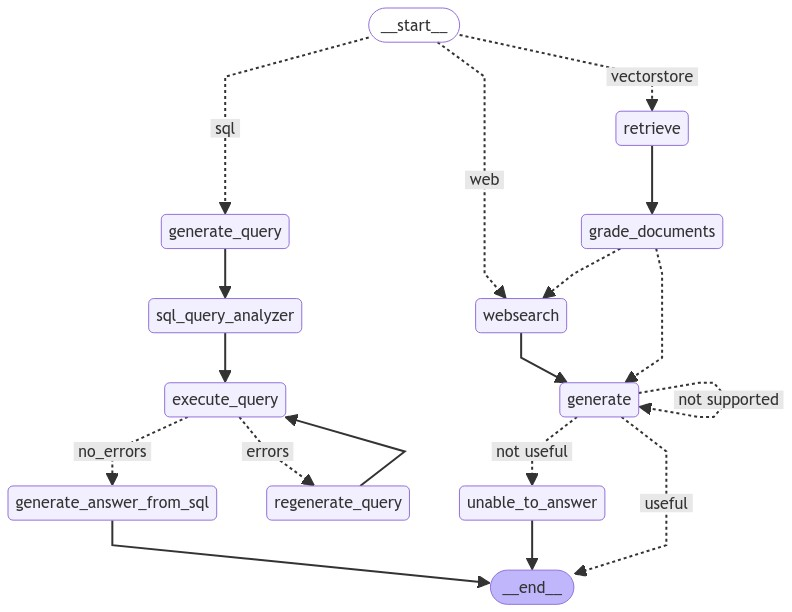

In [27]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [28]:
inputs = {"question": "How can I file a claim?"}
answer = app.invoke(inputs)
answer["generation"]

---ROUTE QUESTION---
---ROUTE QUESTION TO VECTOR DATABASE---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION ADDRESSES QUESTION---


'To file a claim with Citi, please provide the required information, including a description of your loss, the amount of your loss, and an explanation for why the original check is needed. You can also write to us at Citibank Client Services, P.O. Box 769014, San Antonio, TX 78245-9989.'

In [29]:
inputs = {"question": "Who is Citi Ceo?"}
answer = app.invoke(inputs)
answer["generation"]

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---DECISION: GENERATION ADDRESSES QUESTION---


"According to the context, Citi's CEO is Jane Fraser. She became CEO in March 2021 and has been leading the bank since then."

In [30]:
inputs = {"question": "Whats my total spending in the month of May?"}
answer = app.invoke(inputs)
answer["generation"]

---ROUTE QUESTION---
---ROUTE QUESTION TO SQL DATABASE---
---GENERATE SQL QUERY---
---ANALYZING THE SQL QUERY CORRECTNESS---
query_changed='no' query="SELECT SUM(t.Amount) FROM transactions t WHERE t.Date BETWEEN DATE('2024-05-01') AND DATE('2024-05-31') AND t.AccountNumber = 'ACC_NUM';"
---EXCEUTING SQL---
SELECT SUM(t.Amount) FROM transactions t WHERE t.Date BETWEEN DATE('2024-05-01') AND DATE('2024-05-31') AND t.AccountNumber = '1234567892';
---QUERY RAN SUCCESSFULLY---
---DECISION: QUERY CORRECT; SEND TO GENERATE ANSWER FROM SQL---
---GENERATING ANSWER FROM QUERY---


'Your total spending in May was $550.'